In [67]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy import interpolate
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [68]:
#w_list = sorted(glob("data/water_data/*.csv"))
df = pd.read_csv("data_2012~2021 impute_tototf.csv")

In [69]:
# 훈련 데이터 수집
# 실험 결과 "tototf", "fw_1019630" 두가지만 사용할때가 가장 좋았음
# inf의 이상치는 24000을 기준으로 이상

train_data = []
train_label = []
train_data_append = train_data.append
train_label_append = train_label.append

df = df.replace(" ", np.nan)
df = dict(df)
for j in tqdm(range(len(df["inf"])-1)):
    # 라벨이 이상하면 패스 : 0이하이거나, nan이거나, 24000 이상의 이상치거나
    if (df["inf"][j+1] <= 0) or (df["inf"][j+1] != df["inf"][j+1]) or (df["inf"][j+1] > 24000):
        continue
    # 데이터가 이상하면 패스
    if (df["inf"][j] <= 0) or (df["inf"][j] != df["inf"][j]) or (df["inf"][j] > 24000):
        continue
    if (df["fw_1019630"][j] <= 0) or (df["fw_1019630"][j] != df["fw_1019630"][j]):
        continue

    train_data_append([df["inf"][j], df["fw_1019630"][j], df["tototf"][j]])
    train_label_append(df["inf"][j+1])

100%|██████████| 264959/264959 [00:08<00:00, 30261.70it/s]


In [70]:
#train_data = np.delete(train_data, 2, 1)

print(np.array(train_data).shape)
print(np.array(train_label).shape)
train_data = np.array(train_data)
train_label = np.array(train_label)

(240123, 3)
(240123,)


In [71]:
# 검증
# inf wl tototf
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)
print(mean_absolute_error(model.predict(X_test), y_test))
model = XGBRegressor()
model.fit(X_train, y_train)
print(mean_absolute_error(model.predict(X_test), y_test))
print(model.feature_importances_)
model = RandomForestRegressor()
model.fit(X_train, y_train)
print(mean_absolute_error(model.predict(X_test), y_test))
print(model.feature_importances_)

65.65357627697827
64.99142798132432
[0.6217937  0.00281009 0.37539622]
71.34426207019757
[0.7872625  0.00510727 0.20763023]


In [72]:
model = XGBRegressor()
model.fit(train_data, train_label)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
df = pd.read_csv("data_2012~2021 impute_tototf.csv", index_col=0)
df_2022 = pd.read_csv("data_2022 impute_tototf.csv", index_col=0)

column = "inf"
print(f"nan count of {column} : {df[str(column)].isna().sum()}")
print(f"under zero count of {column} : {(df[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(df[str(column)] > 24000).sum()}")
print("-----------")
print(f"nan count of {column} : {df_2022[str(column)].isna().sum()}")
print(f"under zero count of {column} : {(df_2022[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(df_2022[str(column)] > 24000).sum()}")

impute_df = dict(df.copy())
impute_2022 = dict(df_2022.copy())

nan count of inf : 707
under zero count of inf : 18046
anomaly count of inf : 2
-----------
nan count of inf : 36
under zero count of inf : 1070
anomaly count of inf : 0


In [74]:
# dict 리팩토링 완료

for i in tqdm(range(len(impute_df["inf"])-1)):
    # 타겟이 0이하이거나 nan이거나 이상치일때
    if (impute_df["inf"][i+1] <= 0) or (impute_df["inf"][i+1] != impute_df["inf"][i+1]) or (impute_df["inf"][i+1] > 24000):
        # tototf 데이터가 모두 정상일때
        if (impute_df["inf"][i] > 0) and (impute_df["inf"][i] == impute_df["inf"][i]) and (impute_df["inf"][i] <= 24000):
            # fw_1019630 데이터가 모두 정상일때
            if (impute_df["fw_1019630"][i] > 0) and (impute_df["fw_1019630"][i] == impute_df["fw_1019630"][i]):
                impute_df["inf"][i+1] = model.predict(np.array([impute_df["inf"][i], impute_df["fw_1019630"][i], impute_df["tototf"][i]]).reshape(1,-1))

for i in tqdm(range(len(df_2022["tototf"])-1)):
    if (df_2022["inf"][i+1] <= 0) or (df_2022["inf"][i+1] != df_2022["inf"][i+1]) or (df_2022["inf"][i+1] > 24000):
        # tototf 데이터가 모두 정상일때
        if (df_2022["inf"][i] > 0) and (df_2022["inf"][i] == df_2022["inf"][i]) and (df_2022["inf"][i] <= 24000):
            # fw_1019630 데이터가 모두 정상일때
            if (df_2022["fw_1019630"][i] > 0) and (df_2022["fw_1019630"][i] == df_2022["fw_1019630"][i]):
                df_2022["inf"][i+1] = model.predict(np.array([df_2022["inf"][i], df_2022["fw_1019630"][i], df_2022["tototf"][i]]).reshape(1,-1))


100%|██████████| 11375/11375 [00:03<00:00, 3446.72it/s]


In [75]:
impute_df = pd.DataFrame.from_dict(impute_df)
df_2022 = pd.DataFrame.from_dict(df_2022)

column = "inf"
print(f"nan count of {column} : {impute_df[str(column)].isna().sum()}")
print(f"zero count of {column} : {(impute_df[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(impute_df[str(column)] > 24000).sum()}")
print("-----------")
print(f"nan count of {column} : {df_2022[str(column)].isna().sum()}")
print(f"zero count of {column} : {(df_2022[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(df_2022[str(column)] > 24000).sum()}")

nan count of inf : 0
zero count of inf : 7
anomaly count of inf : 0
-----------
nan count of inf : 0
zero count of inf : 0
anomaly count of inf : 0


In [76]:
# 남아있는 0 이하는 보간으로 보정

impute_df["inf"] = impute_df["inf"].apply(lambda x: x if x>0 else np.nan)
impute_df["inf"] = impute_df["inf"].interpolate()

In [77]:
column = "inf"
print(f"nan count of {column} : {impute_df[str(column)].isna().sum()}")
print(f"zero count of {column} : {(impute_df[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(impute_df[str(column)] > 24000).sum()}")
print("-----------")
print(f"nan count of {column} : {df_2022[str(column)].isna().sum()}")
print(f"zero count of {column} : {(df_2022[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(df_2022[str(column)] > 24000).sum()}")

nan count of inf : 0
zero count of inf : 0
anomaly count of inf : 0
-----------
nan count of inf : 0
zero count of inf : 0
anomaly count of inf : 0


In [78]:
impute_df.to_csv("data_2012~2021 impute_tototf+inf.csv")
df_2022.to_csv("data_2022 impute_tototf+inf.csv")

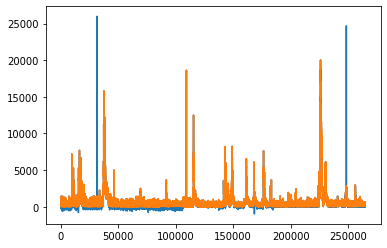

In [79]:
import matplotlib.pyplot as plt
plt.plot(df["inf"].values)
plt.plot(impute_df["inf"].values)